In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import re
import json
import pickle as pkl
from os.path import join
from tqdm.auto import trange, tqdm
from os.path import join
from easydict import EasyDict as edict
import numpy as np
import torch as th
import einops
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from os.path import join
import sys
sys.path.append('/n/home12/binxuwang/Github/DiffusionReasoning')
from edm_utils import parse_train_logfile
from dataset_utils import onehot2attr_tsr
from stats_plot_utils import estimate_CI, shaded_error, saveallforms, shaded_error, add_rectangles
# from rule_utils import get_rule_list, get_obj_list, get_rule_img, check_consistent
from rule_new_utils import get_rule_annot
from GPT_models.GPT_RAVEN_model_lib import MultiIdxGPT2Model, completion_eval, seqtsr2imgtsr
from eval_memorization_utils import eval_memorization_all_level_sample_tsr, get_RAVEN_dataset, extract_row_mat_set, extract_panel_mat_set, extract_attr_row_mat_set, extract_attr_panel_mat_set, \
    compute_memorization_tab_through_training, visualize_memorization_dynamics, visualize_memorization_with_ctrl_dynamics, compute_memorization_binary_joint, extract_training_set_row_panel_sets,\
        check_fraction_train_set_idxlist
from posthoc_analysis_utils import sweep_collect_sample, sweep_collect_eval_data, extract_rule_list_from_eval_col, format_rule_list_to_mat, extract_and_convert

# %%
tabdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Tables"

GPT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven"
DiT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
SiT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results"
SSM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Mamba_raven"
EDM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"

figdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning"
GPTfigdir = join(figdir, "GPT2_raven")
EDMfigdir = join(figdir, "EDM_raven")
DiTfigdir = join(figdir, "DiT_raven")
SiTfigdir = join(figdir, "SiT_raven")
SSMfigdir = join(figdir, "SSM_raven")
memroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/memorization_dynamics"
figsyndir = join(memroot, "synopsis")

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
figroot = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_panel_memorization_dissect'

In [20]:
examples_per_rule = 400
heldout_ids = (1, 16, 20, 34, 37)
train_tsr_X, train_tsr_y = get_RAVEN_dataset(n_classes=40, cmb_per_class=examples_per_rule, heldout_ids=heldout_ids, cmb_offset=0, cache=True)
train_X_sample_set, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col = extract_training_set_row_panel_sets(train_tsr_X)

train_tsr_X_2, train_tsr_y_2 = get_RAVEN_dataset(n_classes=40, cmb_per_class=examples_per_rule, heldout_ids=(), cmb_offset=45000, cache=True)
train_X_sample_set_2, train_X_row_set_2, train_X_panel_set_2, train_X_row_set_attr_col_2, train_X_panel_set_attr_col_2 = extract_training_set_row_panel_sets(train_tsr_X_2,outtype=list)

ref_mem_dict400 = eval_memorization_all_level_sample_tsr(train_tsr_X_2, train_X_sample_set, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col)
pkl.dump(ref_mem_dict400, open(join(figsyndir, "RPM_overlap_data400.pkl"), "wb"))

: 

In [4]:
ref_mem_dict400 = pkl.load(open(join(figsyndir, "RPM_overlap_data400.pkl"), "rb"))
ref_mem_dict400

{'mem_samplecnt': 0,
 'mem_samplefrac': 0.0,
 'mem_rowcnt': 0,
 'mem_rowfrac': 0.0,
 'mem_pancnt': 17888,
 'mem_panfrac': 0.12422222222222222,
 'mem_attr0_rowcnt': 46,
 'mem_attr0_rowfrac': 0.0009583333333333333,
 'mem_attr0_pancnt': 108753,
 'mem_attr0_panfrac': 0.7552291666666666,
 'mem_attr1_rowcnt': 5,
 'mem_attr1_rowfrac': 0.00010416666666666667,
 'mem_attr1_pancnt': 110119,
 'mem_attr1_panfrac': 0.7647152777777778,
 'mem_attr2_rowcnt': 12,
 'mem_attr2_rowfrac': 0.00025,
 'mem_attr2_pancnt': 109452,
 'mem_attr2_panfrac': 0.7600833333333333}

In [21]:
examples_per_rule = 40000
heldout_ids = (1, 16, 20, 34, 37)
train_tsr_X, train_tsr_y = get_RAVEN_dataset(n_classes=40, cmb_per_class=examples_per_rule, heldout_ids=heldout_ids, cmb_offset=0, cache=True)
train_X_sample_set, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col = extract_training_set_row_panel_sets(train_tsr_X)

train_tsr_X_2, train_tsr_y_2 = get_RAVEN_dataset(n_classes=40, cmb_per_class=examples_per_rule, heldout_ids=(), cmb_offset=45000, cache=True)
train_X_sample_set_2, train_X_row_set_2, train_X_panel_set_2, train_X_row_set_attr_col_2, train_X_panel_set_attr_col_2 = extract_training_set_row_panel_sets(train_tsr_X_2,outtype=list)

ref_mem_dict40000 = eval_memorization_all_level_sample_tsr(train_tsr_X_2, train_X_sample_set, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col)
pkl.dump(ref_mem_dict40000, open(join(figsyndir, "RPM_overlap_data40000.pkl"), "wb"))

### 4000 sampler per rule case

In [5]:
examples_per_rule = 4000
heldout_ids = (1, 16, 20, 34, 37)
train_tsr_X, train_tsr_y = get_RAVEN_dataset(n_classes=40, cmb_per_class=examples_per_rule, heldout_ids=heldout_ids, cmb_offset=0, cache=True)
train_X_sample_set, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col = extract_training_set_row_panel_sets(train_tsr_X)

train_tsr_X_2, train_tsr_y_2 = get_RAVEN_dataset(n_classes=40, cmb_per_class=examples_per_rule, heldout_ids=(), cmb_offset=45000, cache=True)
train_X_sample_set_2, train_X_row_set_2, train_X_panel_set_2, train_X_row_set_attr_col_2, train_X_panel_set_attr_col_2 = extract_training_set_row_panel_sets(train_tsr_X_2,outtype=list)

# samples_per_rule = 50
# sample_X_ctrl, sample_y_ctrl = get_RAVEN_dataset(n_classes=40, cmb_per_class=samples_per_rule, heldout_ids=(), cmb_offset=85000, cache=True)
# mem_stats_df = compute_memorization_tab_through_training(sample_col, eval_col, train_X_sample_set, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col, abinit=True)
# mem_stats_df.to_csv(join(figexpdir, "memorization_stats_train_set.csv"))
# print(mem_stats_df.tail(5))
# figh = visualize_memorization_dynamics(mem_stats_df, expname=expname)
# saveallforms(figexpdir, "memorization_dynamics_train_set", figh)

In [5]:
ref_mem_dict4000 = eval_memorization_all_level_sample_tsr(train_tsr_X_2, train_X_sample_set, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col)

In [8]:
pkl.dump(ref_mem_dict4000, open(join(figsyndir, "RPM_overlap_data4000.pkl"), "wb"))

In [ ]:


visualize_memorization_dynamics(ref_mem_dict4000, expname="RPM_overlap_data4000", figdir=figsyndir)

In [10]:
!basename {memroot}/090*

090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204


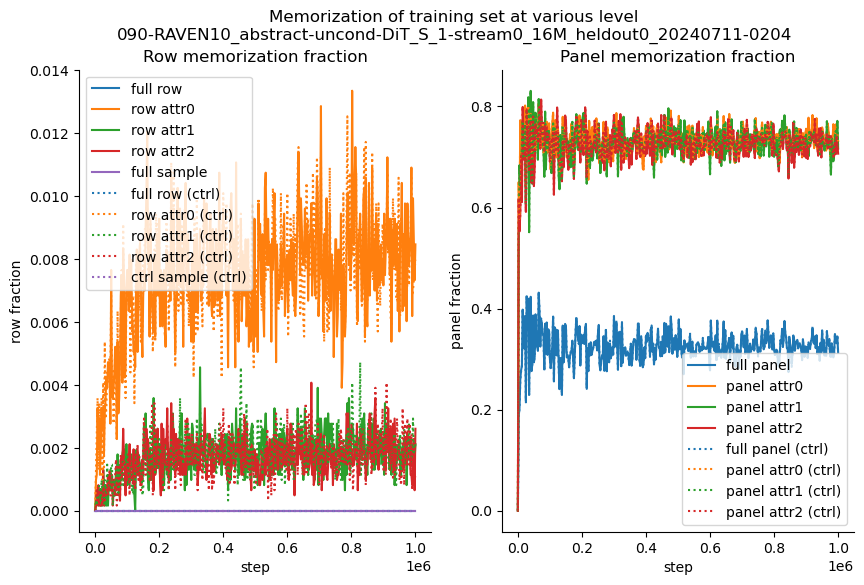

In [11]:
# Define the root directory
# Iterate through all subdirectories and files
# for figexpdir, _, files in os.walk(memroot):
# Get the experiment name
# expname = os.path.basename(figexpdir)
expname = "090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204"
figexpdir = join(memroot, expname)
try:
    mem_stats_df = pd.read_csv(join(figexpdir, "memorization_stats_train_set.csv"))
    mem_stats_ctrl_df = pd.read_csv(join(figexpdir, "memorization_stats_ctrl_set.csv"), index_col=0)
except FileExistsError:
    print(f"Skipping {expname}")
    # continue
figh = visualize_memorization_with_ctrl_dynamics(mem_stats_df, mem_stats_ctrl_df, expname=expname)
# get axis 0 
ax0 = figh.get_axes()[0]
# saveallforms(figexpdir, "memorization_dynamics_train_set_ctrl_set", figh)

In [14]:
list(ref_mem_dict4000)

['mem_samplecnt',
 'mem_samplefrac',
 'mem_rowcnt',
 'mem_rowfrac',
 'mem_pancnt',
 'mem_panfrac',
 'mem_attr0_rowcnt',
 'mem_attr0_rowfrac',
 'mem_attr0_pancnt',
 'mem_attr0_panfrac',
 'mem_attr1_rowcnt',
 'mem_attr1_rowfrac',
 'mem_attr1_pancnt',
 'mem_attr1_panfrac',
 'mem_attr2_rowcnt',
 'mem_attr2_rowfrac',
 'mem_attr2_pancnt',
 'mem_attr2_panfrac']

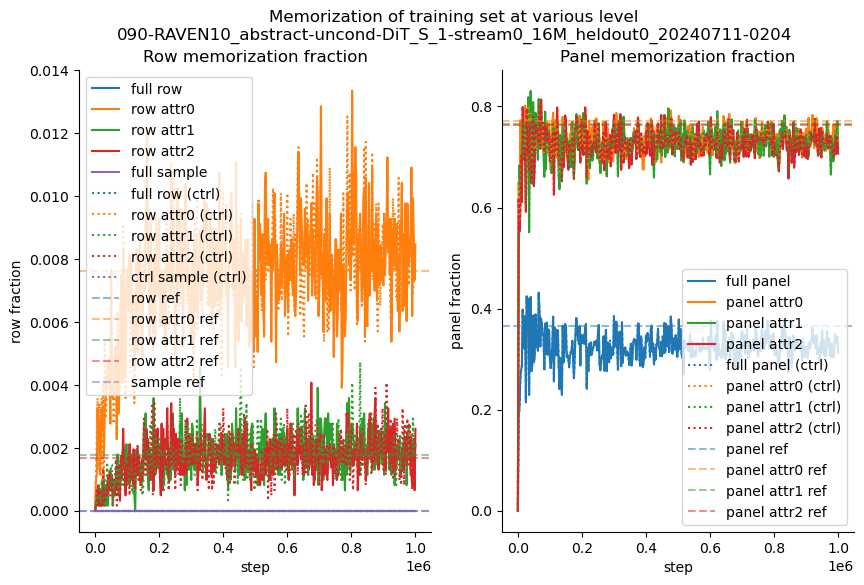

In [19]:
figh = visualize_memorization_with_ctrl_dynamics(mem_stats_df, mem_stats_ctrl_df, expname=expname,
                                                 refdict=ref_mem_dict4000)
saveallforms(figexpdir, "memorization_dynamics_train_set_ctrl_set_wbaseline", figh)
# get axis 0 
# ax0 = figh.get_axes()[0]
# ax0.axhline(ref_mem_dict4000['mem_samplefrac'], color='C0', linestyle='--', label='sample overlap')
# ax0.axhline(ref_mem_dict4000['mem_rowfrac'], color='C1', linestyle='--', label='row overlap')
# ax0.axhline(ref_mem_dict4000['mem_attr0_rowfrac'], color='C2', linestyle='--', label='panel overlap')
# ax0.axhline(ref_mem_dict4000['mem_attr1_rowfrac'], color='C3', linestyle='--', label='panel overlap')
# ax0.axhline(ref_mem_dict4000['mem_attr2_rowfrac'], color='C4', linestyle='--', label='panel overlap')
figh.show()

In [130]:
eval_memorization_all_level_sample_tsr(train_tsr_X_2, train_X_sample_set, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col)

{'mem_samplecnt': 0,
 'mem_samplefrac': 0.0,
 'mem_rowcnt': 0,
 'mem_rowfrac': 0.0,
 'mem_pancnt': 527566,
 'mem_panfrac': 0.3663652777777778,
 'mem_attr0_rowcnt': 3652,
 'mem_attr0_rowfrac': 0.007608333333333333,
 'mem_attr0_pancnt': 1110337,
 'mem_attr0_panfrac': 0.7710673611111111,
 'mem_attr1_rowcnt': 856,
 'mem_attr1_rowfrac': 0.0017833333333333334,
 'mem_attr1_pancnt': 1100982,
 'mem_attr1_panfrac': 0.7645708333333333,
 'mem_attr2_rowcnt': 802,
 'mem_attr2_rowfrac': 0.0016708333333333334,
 'mem_attr2_pancnt': 1099894,
 'mem_attr2_panfrac': 0.7638152777777778}

In [131]:
pancnt, panfrac, idx_list = check_fraction_train_set_idxlist(train_X_panel_set_2, train_X_panel_set)
sample_total = len(train_tsr_X_2)
row_total = sample_total * 3
panel_total = len(train_X_panel_set_2)
assert panel_total == sample_total * 9 
panel_mem_binary_vec = np.zeros((panel_total, ), dtype=bool)
panel_mem_binary_vec[idx_list] = True
panel_mem_bin_row_mat = panel_mem_binary_vec.reshape((row_total, 3))
panel_mem_bin_sample_mat = panel_mem_binary_vec.reshape((sample_total, 9))
rule_sep_panmem_frac = np.zeros((40, ))
for rule_id in range(40):
    panmem_frac = panel_mem_bin_sample_mat[train_tsr_y_2 == rule_id,:].mean()
    rule_sep_panmem_frac[rule_id] = panmem_frac
    print(f"Rule {rule_id}: {panmem_frac}")

Rule 0: 0.4220833333333333
Rule 1: 0.41175
Rule 2: 0.4215833333333333
Rule 3: 0.4158611111111111
Rule 4: 0.41925
Rule 5: 0.4133611111111111
Rule 6: 0.4141666666666667
Rule 7: 0.021416666666666667
Rule 8: 0.010694444444444444
Rule 9: 0.06263888888888888
Rule 10: 0.42291666666666666
Rule 11: 0.4206944444444444
Rule 12: 0.4266666666666667
Rule 13: 0.4308888888888889
Rule 14: 0.4250833333333333
Rule 15: 0.41741666666666666
Rule 16: 0.4187222222222222
Rule 17: 0.0038888888888888888
Rule 18: 0.0019722222222222224
Rule 19: 0.03166666666666667
Rule 20: 0.42627777777777776
Rule 21: 0.4226388888888889
Rule 22: 0.4215833333333333
Rule 23: 0.4235
Rule 24: 0.4288888888888889
Rule 25: 0.4165277777777778
Rule 26: 0.41258333333333336
Rule 27: 0.004111111111111111
Rule 28: 0.0019444444444444444
Rule 29: 0.03219444444444444
Rule 30: 0.5019722222222223
Rule 31: 0.5358611111111111
Rule 32: 0.46597222222222223
Rule 33: 0.46116666666666667
Rule 34: 0.5554722222222223
Rule 35: 0.7526111111111111
Rule 36: 0.7

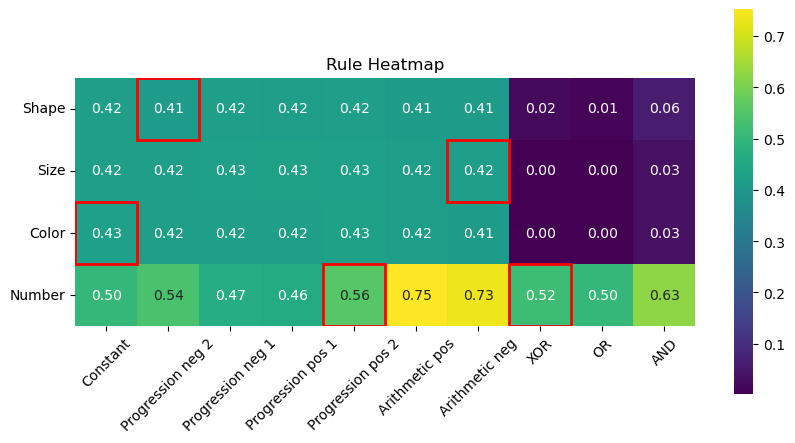

In [32]:
from stats_plot_utils import plot_rule_heatmap
plot_rule_heatmap(rule_sep_panmem_frac.reshape(4,10), );

In [48]:
logic_attr_mask = (np.arange(40) % 10 > 6) & (np.arange(40) < 30)
print(rule_sep_panmem_frac[logic_attr_mask].mean())
print(rule_sep_panmem_frac[~logic_attr_mask].mean()) 

0.01894753086419753
0.46722849462365595


### Load uncond gen samples

In [6]:
from posthoc_analysis_utils import extract_rule_list_from_eval_col_Diffusion

In [7]:
expname = "090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204"
expdir = join(DiT_exproot, expname)
ckptdir = join(expdir, "checkpoints")
outdir = join(expdir, "inpainting_results")
figexpdir = join(figroot, expname)

In [8]:
os.makedirs(figexpdir, exist_ok=True)

In [9]:
# for expfullname in syndf_SiT.full_name:
# tb_record = tb_data_col_SiT[expfullname]
# expname = expfullname.split("/tensorboard_logs")[0]
prefix = "sample_rule_eval_" #"eval_step" if "stream" in expname else "eval_epoch"
eval_col = sweep_collect_eval_data(expname, DiT_exproot, prefix=prefix)
sample_col = sweep_collect_sample(expname, DiT_exproot, non_prefix=prefix, prefix=None)
epoch_list, rule_list_all, consistency_all = extract_rule_list_from_eval_col_Diffusion(eval_col, )
rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all, consistency_all)
eval_sample_num = rule_list_all.shape[1]
print(expname)
if "heldout0" in expname:
    heldout_id = [1, 16, 20, 34, 37]  
else:
    heldout_id = []

Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/samples
example file: 0155000.pt


  0%|          | 0/401 [00:00<?, ?it/s]

Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/samples
example file: ['0155000.pt', '0422500.pt', '0432500.pt', '0715000.pt', '0787500.pt', '0072500.pt', '0277500.pt', 'sample_rule_eval_465000.pt', 'sample_rule_eval_602500.pt', '0707500.pt']


  0%|          | 0/401 [00:00<?, ?it/s]

diffusion model, just fetch ab init generation
(401, 2048, 3) (401, 2, 2048)
090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204


In [10]:
uncond_c3_cnt_end = cons3_rule_cnt_mat[-10:,].mean(axis=0)
uncond_c3_freq_end = uncond_c3_cnt_end / 2048 * 40
uncond_valid_cnt_end = rule_cnt_mat[-10:,].mean(axis=0)
uncond_valid_freq_end = uncond_valid_cnt_end / 2048 / 3 * 40

In [133]:
from scipy.stats import pearsonr, spearmanr


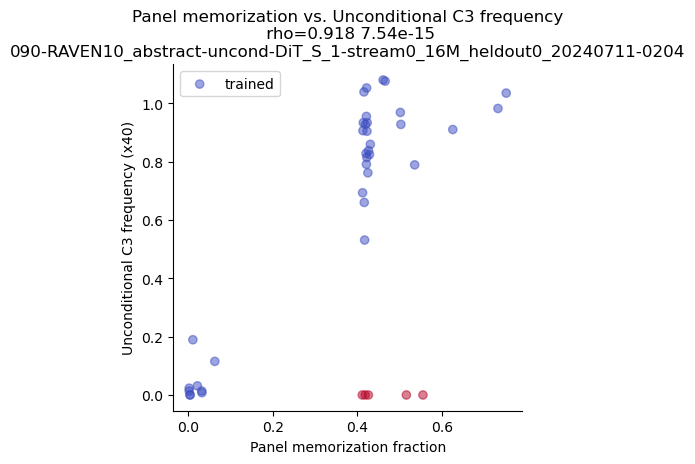

SignificanceResult(statistic=0.7110332906580453, pvalue=1.6936800486972426e-06)

In [139]:
heldout_mask = np.zeros((40,), dtype=bool)
heldout_mask[heldout_id] = True
plt.figure(figsize=[4.5,4.5])
plt.scatter(rule_sep_panmem_frac, uncond_c3_freq_end, 
            c=heldout_mask, cmap='coolwarm', alpha=0.5)
rho, pval = pearsonr(rule_sep_panmem_frac[~heldout_mask], uncond_c3_freq_end[~heldout_mask])
plt.xlabel("Panel memorization fraction")
plt.ylabel("Unconditional C3 frequency (x40)")
plt.title(f"Panel memorization vs. Unconditional C3 frequency\n rho={rho:.3f} {pval:.2e}\n{expname}")
plt.legend(["trained", "heldout"])
saveallforms(figexpdir, "panel_mem_vs_uncond_c3_freq", plt.gcf())
plt.show()

spearmanr(rule_sep_panmem_frac[~heldout_mask], uncond_c3_freq_end[~heldout_mask])

In [44]:
pearsonr(rule_sep_panmem_frac[~heldout_mask], uncond_valid_freq_end[~heldout_mask])

PearsonRResult(statistic=0.8294793976163292, pvalue=7.376417192101497e-10)

In [43]:
pearsonr(rule_sep_panmem_frac[~heldout_mask], uncond_c3_freq_end[~heldout_mask])

PearsonRResult(statistic=0.9184933155300611, pvalue=7.54359587457788e-15)

In [75]:
from rule_new_utils import infer_rule_statistics_from_sample_batch

In [76]:
epoch = 1000000
C3_cnt, C2_cnt, valid_cnt, total_cnt = infer_rule_statistics_from_sample_batch(sample_col[epoch])
assert C3_cnt == eval_col[epoch]['c3_cnt']
assert C2_cnt == eval_col[epoch]['c2_cnt']
assert valid_cnt == eval_col[epoch]['anyvalid_cnt']
print("C3 fraction:", C3_cnt / total_cnt, "C2 fraction:", C2_cnt / total_cnt, "valid fraction:", valid_cnt / total_cnt / 3)

C3 fraction: 0.5712890625 C2 fraction: 0.14208984375 valid fraction: 0.7347005208333334


In [13]:
# train_X_sample_set_2, train_X_row_set_2, train_X_panel_set_2, train_X_row_set_attr_col_2, train_X_panel_set_attr_col_2 = extract_training_set_row_panel_sets(train_tsr_X_2,outtype=list)
# find last 10 epoch
epoch_list = list(eval_col.keys())
epoch_list.sort()
epoch_list = epoch_list[-10:]
sample_cat = th.cat([sample_col[epoch] for epoch in epoch_list], dim=0)
sample_list, row_list, panel_list, row_attr_col_list, panel_attr_col_list = extract_training_set_row_panel_sets(sample_cat, return_set=True, outtype=list)

In [14]:
_,_,idx_list = check_fraction_train_set_idxlist(panel_list, train_X_panel_set)
# pancnt, panfrac, idx_list = check_fraction_train_set_idxlist(
#     train_X_panel_set_attr_col_2[2], train_X_panel_set_attr_col[2])
sample_total = len(train_tsr_X_2)
row_total = sample_total * 3
panel_total = len(train_X_panel_set_2)
assert panel_total == sample_total * 9 
# construct the binary vector and matrix of memorization
panel_mem_binary_vec = np.zeros((panel_total, ), dtype=bool)
panel_mem_binary_vec[idx_list] = True
panel_mem_bin_row_mat = panel_mem_binary_vec.reshape((row_total, 3))
panel_mem_bin_sample_mat = panel_mem_binary_vec.reshape((sample_total, 9))

### Unique mem panel sample correlation

In [109]:
# train_X_sample_set_2, train_X_row_set_2, train_X_panel_set_2, train_X_row_set_attr_col_2, train_X_panel_set_attr_col_2 = extract_training_set_row_panel_sets(train_tsr_X_2,outtype=list)
# find last 10 epoch
epoch_list = list(eval_col.keys())
epoch_list.sort()
epoch_list = epoch_list[-7:]
sample_cat = th.cat([sample_col[epoch] for epoch in epoch_list], dim=0)
sample_list, row_list, panel_list, row_attr_col_list, panel_attr_col_list = extract_training_set_row_panel_sets(sample_cat, return_set=False)

In [110]:
uniq_panels, uniq_panel_cnts = np.unique(panel_list, axis=0, return_counts=True)

In [111]:
sample_cat.shape

torch.Size([14336, 3, 9, 9])

In [112]:
train_tsr_X.shape

torch.Size([14000, 3, 9, 9])

In [113]:
train_X_sample_arr, train_X_row_arr, train_X_panel_arr, train_X_row_arr_attr_col, train_X_panel_arr_attr_col = extract_training_set_row_panel_sets(train_tsr_X, return_set=False)


In [114]:
train_uniq_panels, train_uniq_panel_cnts = np.unique(train_X_panel_arr, axis=0, return_counts=True)

In [115]:
train_uniq_panel_cnts.max()

13

In [116]:
uniq_panels_set = set([tuple(panel) for panel in uniq_panels])
uniq_panels_dict = {tuple(panel): cnt for panel, cnt in zip(uniq_panels, uniq_panel_cnts)}
train_uniq_panels_set = set([tuple(panel) for panel in train_uniq_panels])
train_panel_dict = {tuple(panel): cnt for panel, cnt in zip(train_uniq_panels, train_uniq_panel_cnts)}  
mem_panel_set = uniq_panels_set.intersection(train_uniq_panels_set)

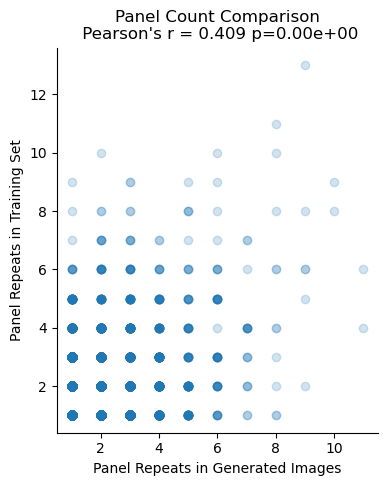

In [122]:
mem_panel_cnt_gen = [uniq_panels_dict[panel] for panel in mem_panel_set]
mem_panel_cnt_train = [train_panel_dict[panel] for panel in mem_panel_set]
plt.figure(figsize=(5,5))
plt.scatter(mem_panel_cnt_gen, mem_panel_cnt_train, alpha=0.2)
rho, pval = pearsonr(mem_panel_cnt_gen, mem_panel_cnt_train)
plt.axis('image')
plt.xlabel("Panel Repeats in Generated Images")
plt.ylabel("Panel Repeats in Training Set")
plt.title(f"Panel Count Comparison\n Pearson's r = {rho:.3f} p={pval:.2e}")
saveallforms(figexpdir, "gen_train_panel_count_comparison", plt.gcf())
plt.show()
# for idx, panel in enumerate(mem_panel_set):
#     mem_panel_cnt_gen[idx] = uniq_panel_cnts[uniq_panels_set.index(panel)]
#     mem_panel_cnt_train[idx] = train_uniq_panel_cnts[train_uniq_panels_set.index(panel)]

In [88]:
uniq_panel_cnts.max()

16

In [142]:
ref_train_mem_stats = eval_memorization_all_level_sample_tsr(train_tsr_X_2, train_X_sample_set, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col)

ValueError: If using all scalar values, you must pass an index

In [145]:
pd.DataFrame({0:ref_train_mem_stats}).T

: 

In [20]:
pancnt, panfrac, idx_list = check_fraction_train_set_idxlist(
    train_X_panel_set_attr_col_2[2], train_X_panel_set_attr_col[2])
sample_total = len(train_tsr_X_2)
row_total = sample_total * 3
panel_total = len(train_X_panel_set_2)
assert panel_total == sample_total * 9 
# construct the binary vector and matrix of memorization
panel_mem_binary_vec = np.zeros((panel_total, ), dtype=bool)
panel_mem_binary_vec[idx_list] = True
panel_mem_bin_row_mat = panel_mem_binary_vec.reshape((row_total, 3))
panel_mem_bin_sample_mat = panel_mem_binary_vec.reshape((sample_total, 9))

In [21]:
for rule_id in range(40):
    panmem_frac = panel_mem_bin_sample_mat[train_tsr_y_2 == rule_id,:].mean()
    print(f"Rule {rule_id}: {panmem_frac}")

Rule 0: 0.7171388888888889
Rule 1: 0.7145555555555556
Rule 2: 0.7183611111111111
Rule 3: 0.7085833333333333
Rule 4: 0.7199722222222222
Rule 5: 0.7177222222222223
Rule 6: 0.7101111111111111
Rule 7: 0.7152777777777778
Rule 8: 0.7115555555555556
Rule 9: 0.7125
Rule 10: 0.7202222222222222
Rule 11: 0.71575
Rule 12: 0.7184444444444444
Rule 13: 0.7170555555555556
Rule 14: 0.7197222222222223
Rule 15: 0.7113055555555555
Rule 16: 0.7182222222222222
Rule 17: 0.7135
Rule 18: 0.71775
Rule 19: 0.7069722222222222
Rule 20: 1.0
Rule 21: 1.0
Rule 22: 1.0
Rule 23: 1.0
Rule 24: 1.0
Rule 25: 1.0
Rule 26: 1.0
Rule 27: 0.014972222222222222
Rule 28: 0.008055555555555555
Rule 29: 0.09097222222222222
Rule 30: 0.87275
Rule 31: 0.8905555555555555
Rule 32: 0.8702222222222222
Rule 33: 0.8628333333333333
Rule 34: 0.9023888888888889
Rule 35: 0.9829444444444444
Rule 36: 0.9698333333333333
Rule 37: 0.9342777777777778
Rule 38: 0.9027222222222222
Rule 39: 0.9525


In [6]:
eval_memorization_all_level_sample_tsr(sample_X_ctrl, train_X_sample_set, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col)

{'mem_samplecnt': 0,
 'mem_samplefrac': 0.0,
 'mem_rowcnt': 0,
 'mem_rowfrac': 0.0,
 'mem_pancnt': 2450,
 'mem_panfrac': 0.1361111111111111,
 'mem_attr0_rowcnt': 3,
 'mem_attr0_rowfrac': 0.0005,
 'mem_attr0_pancnt': 13644,
 'mem_attr0_panfrac': 0.758,
 'mem_attr1_rowcnt': 3,
 'mem_attr1_rowfrac': 0.0005,
 'mem_attr1_pancnt': 13715,
 'mem_attr1_panfrac': 0.7619444444444444,
 'mem_attr2_rowcnt': 0,
 'mem_attr2_rowfrac': 0.0,
 'mem_attr2_pancnt': 13578,
 'mem_attr2_panfrac': 0.7543333333333333}

### 400 per rules case

In [49]:
examples_per_rule = 400
heldout_ids = (1, 16, 20, 34, 37)
train_tsr_X, train_tsr_y = get_RAVEN_dataset(n_classes=40, cmb_per_class=examples_per_rule, heldout_ids=heldout_ids, cmb_offset=0, cache=True)
train_X_sample_set, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col = extract_training_set_row_panel_sets(train_tsr_X)

train_tsr_X_2, train_tsr_y_2 = get_RAVEN_dataset(n_classes=40, cmb_per_class=examples_per_rule, heldout_ids=(), cmb_offset=45000, cache=True)
train_X_sample_set_2, train_X_row_set_2, train_X_panel_set_2, train_X_row_set_attr_col_2, train_X_panel_set_attr_col_2 = extract_training_set_row_panel_sets(train_tsr_X_2,outtype=list)

# samples_per_rule = 50
# sample_X_ctrl, sample_y_ctrl = get_RAVEN_dataset(n_classes=40, cmb_per_class=samples_per_rule, heldout_ids=(), cmb_offset=85000, cache=True)
# mem_stats_df = compute_memorization_tab_through_training(sample_col, eval_col, train_X_sample_set, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col, abinit=True)
# mem_stats_df.to_csv(join(figexpdir, "memorization_stats_train_set.csv"))
# print(mem_stats_df.tail(5))
# figh = visualize_memorization_dynamics(mem_stats_df, expname=expname)
# saveallforms(figexpdir, "memorization_dynamics_train_set", figh)

In [50]:
eval_memorization_all_level_sample_tsr(train_tsr_X_2, train_X_sample_set, train_X_row_set, train_X_panel_set, train_X_row_set_attr_col, train_X_panel_set_attr_col)

{'mem_samplecnt': 0,
 'mem_samplefrac': 0.0,
 'mem_rowcnt': 0,
 'mem_rowfrac': 0.0,
 'mem_pancnt': 17888,
 'mem_panfrac': 0.12422222222222222,
 'mem_attr0_rowcnt': 46,
 'mem_attr0_rowfrac': 0.0009583333333333333,
 'mem_attr0_pancnt': 108753,
 'mem_attr0_panfrac': 0.7552291666666666,
 'mem_attr1_rowcnt': 5,
 'mem_attr1_rowfrac': 0.00010416666666666667,
 'mem_attr1_pancnt': 110119,
 'mem_attr1_panfrac': 0.7647152777777778,
 'mem_attr2_rowcnt': 12,
 'mem_attr2_rowfrac': 0.00025,
 'mem_attr2_pancnt': 109452,
 'mem_attr2_panfrac': 0.7600833333333333}

In [51]:
pancnt, panfrac, idx_list = check_fraction_train_set_idxlist(train_X_panel_set_2, train_X_panel_set)
sample_total = len(train_tsr_X_2)
row_total = sample_total * 3
panel_total = len(train_X_panel_set_2)
assert panel_total == sample_total * 9 
panel_mem_binary_vec = np.zeros((panel_total, ), dtype=bool)
panel_mem_binary_vec[idx_list] = True
panel_mem_bin_row_mat = panel_mem_binary_vec.reshape((row_total, 3))
panel_mem_bin_sample_mat = panel_mem_binary_vec.reshape((sample_total, 9))
rule_sep_panmem_frac = np.zeros((40, ))
for rule_id in range(40):
    panmem_frac = panel_mem_bin_sample_mat[train_tsr_y_2 == rule_id,:].mean()
    rule_sep_panmem_frac[rule_id] = panmem_frac
    print(f"Rule {rule_id}: {panmem_frac}")

Rule 0: 0.14666666666666667
Rule 1: 0.16361111111111112
Rule 2: 0.14333333333333334
Rule 3: 0.15472222222222223
Rule 4: 0.1511111111111111
Rule 5: 0.13833333333333334
Rule 6: 0.14333333333333334
Rule 7: 0.008055555555555555
Rule 8: 0.004722222222222222
Rule 9: 0.015833333333333335
Rule 10: 0.13361111111111112
Rule 11: 0.14888888888888888
Rule 12: 0.15694444444444444
Rule 13: 0.14916666666666667
Rule 14: 0.14472222222222222
Rule 15: 0.14444444444444443
Rule 16: 0.14972222222222223
Rule 17: 0.0008333333333333334
Rule 18: 0.0005555555555555556
Rule 19: 0.008888888888888889
Rule 20: 0.15916666666666668
Rule 21: 0.15583333333333332
Rule 22: 0.15305555555555556
Rule 23: 0.14333333333333334
Rule 24: 0.15361111111111111
Rule 25: 0.16111111111111112
Rule 26: 0.1525
Rule 27: 0.0008333333333333334
Rule 28: 0.0002777777777777778
Rule 29: 0.008888888888888889
Rule 30: 0.13805555555555554
Rule 31: 0.18666666666666668
Rule 32: 0.1361111111111111
Rule 33: 0.13277777777777777
Rule 34: 0.190833333333333

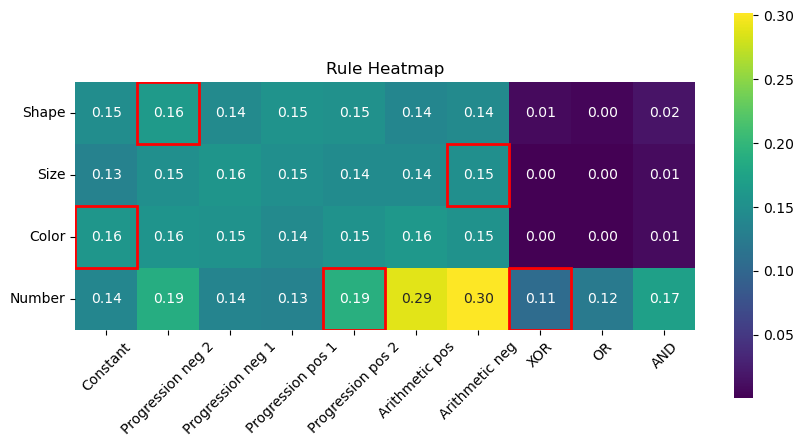

In [52]:
from stats_plot_utils import plot_rule_heatmap
plot_rule_heatmap(rule_sep_panmem_frac.reshape(4,10), );

In [63]:
!basename {DiT_exproot}/101*

101-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_heldout0_20240921-1650


In [ ]:
# expname = "098-RAVEN10_abstract-uncond-DiT_S_1-stream0_016M_heldout0_20240816-0050"
expname = "101-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_heldout0_20240921-1650"

In [64]:
expname = "098-RAVEN10_abstract-uncond-DiT_S_1-stream0_016M_heldout0_20240816-0050"
expname = "101-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_heldout0_20240921-1650"
expdir = join(DiT_exproot, expname)
ckptdir = join(expdir, "checkpoints")
outdir = join(expdir, "inpainting_results")
figexpdir = join(figroot, expname)

In [65]:
# for expfullname in syndf_SiT.full_name:
# tb_record = tb_data_col_SiT[expfullname]
# expname = expfullname.split("/tensorboard_logs")[0]
prefix = "sample_rule_eval_" #"eval_step" if "stream" in expname else "eval_epoch"
eval_col = sweep_collect_eval_data(expname, DiT_exproot, prefix=prefix)
epoch_list, rule_list_all, consistency_all = extract_rule_list_from_eval_col_Diffusion(eval_col, )
rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all, consistency_all)
eval_sample_num = rule_list_all.shape[1]
print(expname)
if "heldout0" in expname:
    heldout_id = [1, 16, 20, 34, 37]  
else:
    heldout_id = []

Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/101-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_heldout0_20240921-1650/samples
example file: 0155000.pt


  0%|          | 0/401 [00:00<?, ?it/s]

diffusion model, just fetch ab init generation
(401, 2048, 3) (401, 2, 2048)
101-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_heldout0_20240921-1650


In [66]:
uncond_c3_cnt_end = cons3_rule_cnt_mat[-10:,].mean(axis=0)
uncond_c3_freq_end = uncond_c3_cnt_end / 2048 * 40
uncond_valid_cnt_end = rule_cnt_mat[-10:,].mean(axis=0)
uncond_valid_freq_end = uncond_valid_cnt_end / 2048 / 3 * 40

PearsonRResult(statistic=0.7240662620389773, pvalue=8.81841302687414e-07)


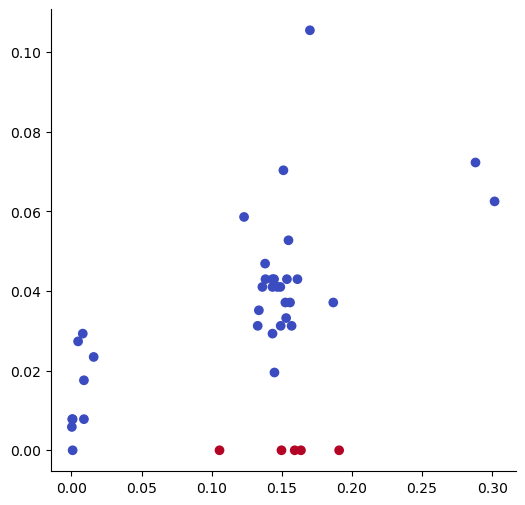

In [67]:
from scipy.stats import pearsonr, spearmanr
heldout_mask = np.zeros((40,), dtype=bool)
heldout_mask[heldout_id] = True
plt.figure(figsize=(6,6))
plt.scatter(rule_sep_panmem_frac, uncond_c3_freq_end, c=heldout_mask, cmap='coolwarm')
print(pearsonr(rule_sep_panmem_frac[~heldout_mask], uncond_c3_freq_end[~heldout_mask]))
# print(pearsonr(rule_sep_panmem_frac[~heldout_mask], uncond_valid_freq_end[~heldout_mask]))

In [ ]:
pearsonr(rule_sep_panmem_frac[~heldout_mask], uncond_valid_freq_end[~heldout_mask])

PearsonRResult(statistic=0.8294793976163292, pvalue=7.376417192101497e-10)

In [ ]:
pearsonr(rule_sep_panmem_frac[~heldout_mask], uncond_c3_freq_end[~heldout_mask])

PearsonRResult(statistic=0.9184933155300611, pvalue=7.54359587457788e-15)